In [2]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import itertools


# Uploading Data

In [3]:
sheep = np.load(r"data\full_numpy_bitmap_sheep.npy")
# print(sheep.shape)
giraffe = np.load(r"data\full_numpy_bitmap_giraffe.npy")
# print(giraffe.shape)
cat = np.load(r"data\full_numpy_bitmap_cat.npy")

sheep = sheep[:2000]
giraffe = giraffe[:2000]
cat = cat[:2000]

Combining Data Sets and Splitting into Training, Validation, Testing Sets

In [4]:
def combine_data(*args):
    X = np.zeros((0,784))
    Y = np.zeros((0,1))
    for i in range(len(args)):
        X = np.concatenate((X, args[i]))
        Y = np.concatenate((Y, np.ones((args[i].shape[0],1))*i))
    Y = Y.reshape(Y.shape[0])
    return X, Y

def split_data(X, Y, split=(0.8,0.1,0.1)):
    # defaulting to an 80/10/10 train/test/val split
    train, test, val = split
    X_train, X_testval, Y_train, Y_testval = train_test_split(X, Y, test_size=test+val, random_state=42, shuffle=True)
    X_test, X_val, Y_test, Y_val = train_test_split(X_testval, Y_testval, test_size=val/(test+val), random_state=42, shuffle=True)
    return X_train, X_test, X_val, Y_train, Y_test, Y_val

X, Y = combine_data(sheep, giraffe, cat)
X_train, X_test, X_val, Y_train, Y_test, Y_val = split_data(X, Y)

Default SVM classifier function<br>
Will call to test each hyperparameter individually

In [5]:
def create_classifier(X_train, Y_train, kernel="linear", degree=1, C=1.0): # default values
    classifier = svm.SVC(kernel=kernel, degree=degree, C=C)
    classifier.fit(X_train, Y_train)
    return classifier

Accuracy

In [6]:
def accuracy(classifier, X_val, Y_val):
    return classifier.score(X_val, Y_val)

# def plot_confusion_matrix(classifier, X_val, Y_val):

Test for best normalization using default values

In [7]:
def test_norm(X_train, Y_train, X_val, Y_val, normalizations):
    data = {"Normalization": [], "Accuracy": []}
    for norm in normalizations:
        if norm is not None:
            scaler = norm
            X_train_norm = scaler.fit_transform(X_train)
            X_val_norm = scaler.transform(X_val)
        else:
            X_train_norm = X_train
            X_val_norm = X_val
        classifier = create_classifier(X_train_norm, Y_train)
        acc = accuracy(classifier, X_val_norm, Y_val)
        data["Normalization"].append(norm)
        data["Accuracy"].append(acc)
    return pd.DataFrame(data)

# normalizations
normalizations = [None, StandardScaler(), MinMaxScaler()]
df = test_norm(X_train, Y_train, X_val, Y_val, normalizations)
print(df)

In [ ]:
def plot_regularization_scores(train_scores, val_scores, title):
    l1_penalties = [1e-7, 1e-5, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(l1_penalties, train_scores, label='Train Score', marker='o')
    plt.plot(l1_penalties, val_scores, label='Validation Score', marker='o')
    plt.xscale('log')
    plt.xlabel('L1 Penalty')
    plt.ylabel('Score')
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

Testing C Values (Kernels: Linear, Polynomial Deg: 2,3,4, RBF)

In [ ]:
def classify_and_df(X_tr, Y_tr, X_val, Y_val, kernel, C_vals, degree=1, title=""):
    data = {"C": [], "Accuracy": []}
    for C_val in C_vals:
        classifier = create_classifier(X_tr, Y_tr, kernel=kernel, degree=degree, C=C_val)
        acc = accuracy(classifier, X_val, Y_val)
        data["C"].append(C_val)
        data["Accuracy"].append(acc)
    plot_regularization_scores(data["Accuracy"], data["C"], title)
    return pd.DataFrame.from_dict(data)

def test_kern_deg(X_tr, Y_tr, X_val, Y_val, kernels, C_vals, degrees, scaler=None, title=""):
    # scale data
    X_train_scaled = scaler.fit_transform(X_tr) if scaler else X_tr
    X_val_scaled = scaler.transform(X_val) if scaler else X_val
    # for each kernel type, test different C values and return dataframe storing C_vals and accuracy data
    for kernel in kernels:
        # if kernel is polynomial, test different degrees
        if kernel == "poly":
            for degree in degrees:
                dataframe = classify_and_df(X_train_scaled, Y_tr, X_val_scaled, Y_val, kernel, C_vals, degree, title=f"{kernel} kernel, degree {degree}")
                yield (kernel, degree, dataframe)
        else:
            dataframe = classify_and_df(X_train_scaled, Y_tr, X_val_scaled, Y_val, kernel, C_vals, title=f"{kernel} kernel")
            yield (kernel, 1, dataframe)

C_vals = [0.0000001, 0.00001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 1000000]
kernels = ["linear", "poly", "rbf"]
degrees = [2, 3, 4]
with open("SVM_results.csv", "w") as f:
    for kernel, degree, df in test_kern_deg(X_train, Y_train, X_val, Y_val, kernels, C_vals, degrees, scaler=StandardScaler()):
        f.write(f"{kernel}_{degree}\n")
        print(df)
        df.to_csv(f, sep='\t', encoding='utf-8', index=False, lineterminator='\n', columns=["C", "Accuracy"])
        f.write('\n')

              C  Accuracy
0  1.000000e-07  0.330000
1  1.000000e-05  0.630000
2  1.000000e-03  0.886667
3  1.000000e-02  0.870000
4  1.000000e-01  0.843333
5  1.000000e+00  0.846667
6  1.000000e+01  0.846667
7  1.000000e+02  0.846667
8  1.000000e+04  0.846667
9  1.000000e+06  0.846667
              C  Accuracy
0  1.000000e-07  0.330000
1  1.000000e-05  0.330000
2  1.000000e-03  0.330000
3  1.000000e-02  0.330000
4  1.000000e-01  0.920000
5  1.000000e+00  0.936667
6  1.000000e+01  0.940000
7  1.000000e+02  0.940000
8  1.000000e+04  0.940000
9  1.000000e+06  0.940000
              C  Accuracy
0  1.000000e-07  0.330000
1  1.000000e-05  0.330000
2  1.000000e-03  0.330000
3  1.000000e-02  0.330000
4  1.000000e-01  0.570000
5  1.000000e+00  0.943333
6  1.000000e+01  0.953333
7  1.000000e+02  0.953333
8  1.000000e+04  0.953333
9  1.000000e+06  0.953333
              C  Accuracy
0  1.000000e-07  0.330000
1  1.000000e-05  0.330000
2  1.000000e-03  0.330000
3  1.000000e-02  0.330000
4  1.000000e

Test Optimal Hyperparameters on Test Set

0.9366666666666666
Normalized confusion matrix
[[0.93859649 0.00877193 0.05263158]
 [0.03030303 0.91919192 0.05050505]
 [0.04597701 0.         0.95402299]]


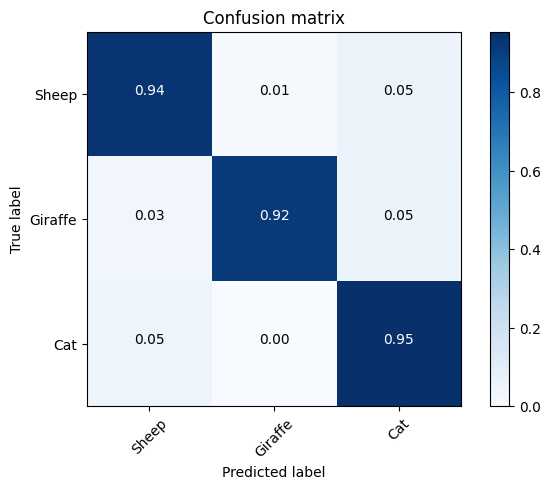

In [ ]:
def train_and_return_confusion_matrix(X_tr, Y_tr, X_test, Y_test, kernel, C, degree=1, scaler=None):
    # scale data
    X_train_scaled = scaler.fit_transform(X_tr) if scaler else X_tr
    X_test_scaled = scaler.transform(X_test) if scaler else X_test
    # train classifier
    classifier = create_classifier(X_train_scaled, Y_tr, kernel=kernel, degree=degree, C=C)
    # return confusion matrix
    print(accuracy(classifier, X_test_scaled, Y_test))
    return metrics.confusion_matrix(Y_test, classifier.predict(X_test_scaled))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = train_and_return_confusion_matrix(X_train, Y_train, X_test, Y_test, kernel="poly", C=10, degree = 3, scaler=StandardScaler())
plot_confusion_matrix(cm, ["Sheep", "Giraffe", "Cat"], normalize=True)

In [ ]:
# def test_kern_deg_reg_none(kernels, degrees, C_vals):
#     data = {"Kernel": [], "Degree": [], "C": [], "Accuracy": []}
#     for kernel in kernels:
#         for degree in degrees:
#             for C in C_vals:
#                 classifier = create_classifier(X_train, Y_train, kernel=kernel, degree=degree, C=C)
#                 acc = accuracy(classifier, X_val, Y_val)
#                 data["C"].append(C)
#                 data["Kernel"].append(kernel)
#                 data["Degree"].append(degree)
#                 data["Accuracy"].append(acc)
#     df = pd.DataFrame(data)
#     return df

# C_vals = [0.01, 0.1, 1, 10]
# kernels = ["linear", "poly", "rbf"]
# degrees = [1, 2, 3, 4, 5]
# df = test_kern_deg_reg_none(kernels, degrees, C_vals)
# print(df)